In [1]:
import laspy
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [14]:
# Check the file structure
file_path = "./Data/303-5059_2015.las"

# Read the LAS file
las = laspy.read(file_path)

In [15]:
# Convert ALL laspy arrays to regular NumPy arrays
points_data = {
    'x': np.array(las.x),
    'y': np.array(las.y), 
    'z': np.array(las.z)
}

# Add intensity if available (convert to numpy)
if hasattr(las, 'intensity'):
    points_data['intensity'] = np.array(las.intensity)

# Add return information if available  
if hasattr(las, 'return_number') and hasattr(las, 'number_of_returns'):
    points_data['return_num'] = np.array(las.return_number)
    points_data['num_returns'] = np.array(las.number_of_returns)

# Add classification if available
if hasattr(las, 'classification'):
    points_data['classification'] = np.array(las.classification)

# Create DataFrame
points = pd.DataFrame(points_data)

print(f"DataFrame shape: {points.shape}")
print(f"Data types: {points.dtypes}")
print("\nFirst few points:")
print(points.head())

DataFrame shape: (18066876, 7)
Data types: x                 float64
y                 float64
z                 float64
intensity          uint16
return_num          uint8
num_returns         uint8
classification      uint8
dtype: object

First few points:
           x           y      z  intensity  return_num  num_returns  \
0  303050.83  5059858.30  16.30       5242           1            2   
1  303051.26  5059857.87  14.51      30146           2            2   
2  303051.03  5059858.11  14.48      32112           1            1   
3  303050.82  5059858.34  14.50      35388           1            1   
4  303050.56  5059858.62  14.64      23592           1            1   

   classification  
0               4  
1               1  
2               1  
3               2  
4               1  


In [22]:
# Extract a small segment of the data for testing
# Let's take points within a small bounding box
x_min, x_max = points['x'].min(), points['x'].max()
y_min, y_max = points['y'].min(), points['y'].max()

# Define a small segment (adjust these values based on your data distribution)
segment_size = 300  # meters - adjust this based on your data scale
segment_x_center = x_min + (x_max - x_min) * 0.1  # 10% from left edge
segment_y_center = y_min + (y_max - y_min) * 0.1  # 10% from bottom edge

# Create a small bounding box segment
segment_mask = (
    (points['x'] >= segment_x_center) & 
    (points['x'] <= segment_x_center + segment_size) &
    (points['y'] >= segment_y_center) & 
    (points['y'] <= segment_y_center + segment_size)
)

segment_points = points[segment_mask].copy()
print(f"Segment points: {len(segment_points):,}")
print(f"Original points: {len(points):,}")
print(f"Segment represents {len(segment_points)/len(points)*100:.2f}% of total data")

Segment points: 1,520,267
Original points: 18,066,876
Segment represents 8.41% of total data


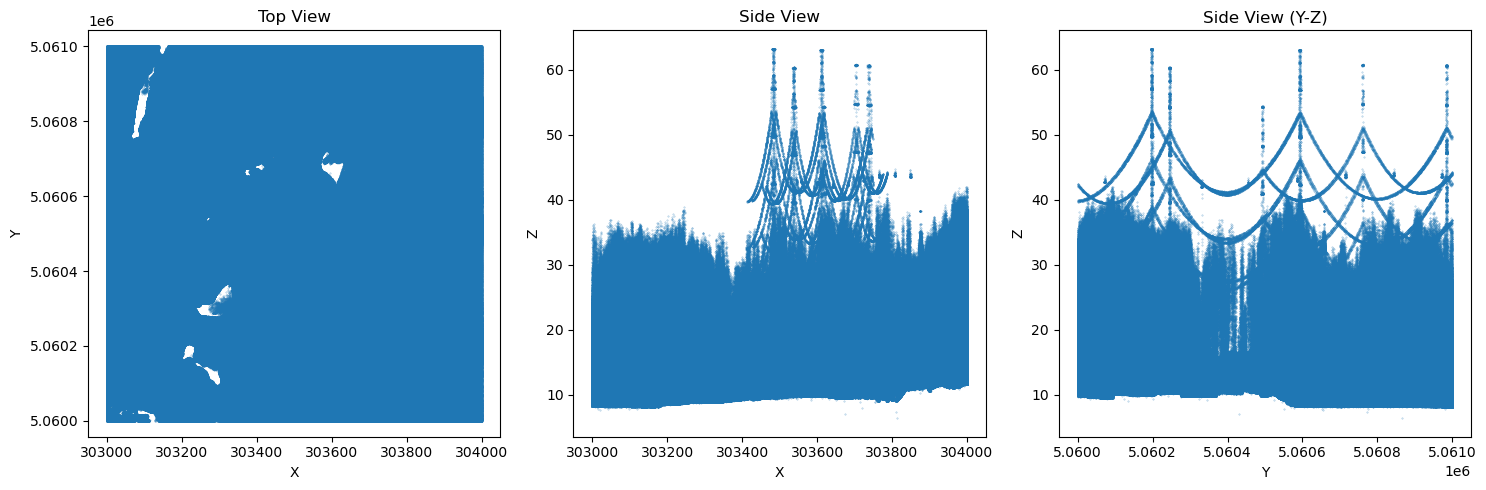

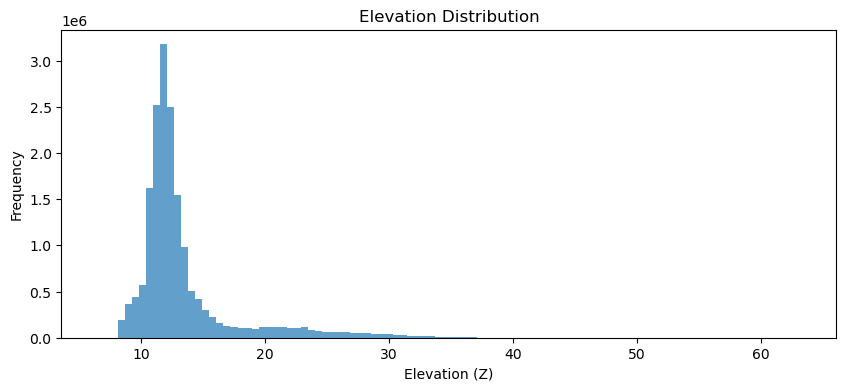

In [13]:
# Plot the point cloud (2D overview)
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(points['x'].values, points['y'].values, s=0.1, alpha=0.5)  # Use .values to be safe
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Top View')
plt.axis('equal')

plt.subplot(132)
plt.scatter(points['x'].values, points['z'].values, s=0.1, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Side View')

plt.subplot(133)
plt.scatter(points['y'].values, points['z'].values, s=0.1, alpha=0.5)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Side View (Y-Z)')

plt.tight_layout()
plt.show()

# Height distribution
plt.figure(figsize=(10, 4))
plt.hist(points['z'].values, bins=100, alpha=0.7)
plt.xlabel('Elevation (Z)')
plt.ylabel('Frequency')
plt.title('Elevation Distribution')
plt.show()


Performing BIC analysis...
Fitting GMM with 1 components...
  Components: 1, BIC: 1026098.48, AIC: 1026011.08
Fitting GMM with 2 components...
  Components: 2, BIC: 957097.05, AIC: 956912.55
Fitting GMM with 3 components...
  Components: 3, BIC: 878021.39, AIC: 877739.80
Fitting GMM with 4 components...
  Components: 4, BIC: 803839.78, AIC: 803461.08
Fitting GMM with 5 components...
  Components: 5, BIC: 770724.22, AIC: 770248.42
Fitting GMM with 6 components...
  Components: 6, BIC: 756508.05, AIC: 755935.14
Fitting GMM with 7 components...
  Components: 7, BIC: 738033.24, AIC: 737363.23
Fitting GMM with 8 components...
  Components: 8, BIC: 705136.29, AIC: 704369.18
Fitting GMM with 9 components...
  Components: 9, BIC: 685871.30, AIC: 685007.09
Fitting GMM with 10 components...
  Components: 10, BIC: 648483.39, AIC: 647522.07
Fitting GMM with 11 components...
  Components: 11, BIC: 637124.35, AIC: 636065.94
Fitting GMM with 12 components...
  Components: 12, BIC: 629316.86, AIC: 62

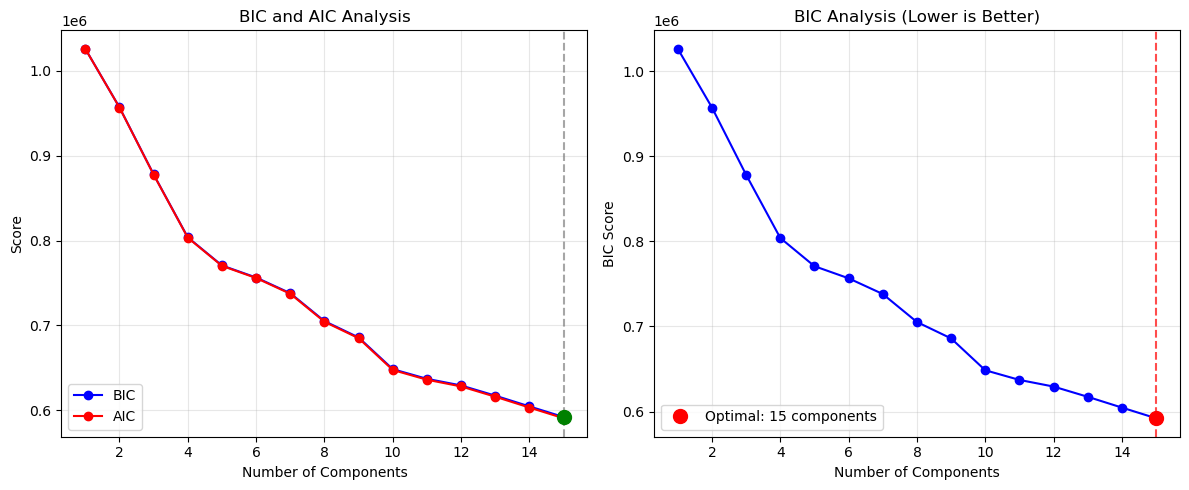


Fitting final GMM with 15 components...


In [ ]:
# Prepare features for GMM
features = segment_points[['x', 'y', 'z']].values

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# BIC Analysis to determine optimal number of components
print("\nPerforming BIC analysis...")

# Define range of components to test
min_components = 1
max_components = 15
n_components_range = range(min_components, max_components + 1)

bic_scores = []
aic_scores = []
gmm_models = []

for n_components in n_components_range:
    print(f"Fitting GMM with {n_components} components...")
    
    # Fit GMM with different initialization to avoid local minima
    best_gmm = None
    best_lower_bound = -np.inf
    
    for init in range(3):  # Try 3 different initializations
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type='full',
            random_state=init,
            init_params='kmeans'
        )
        gmm.fit(scaled_features)
        
        if gmm.lower_bound_ > best_lower_bound:
            best_lower_bound = gmm.lower_bound_
            best_gmm = gmm
    
    bic_scores.append(best_gmm.bic(scaled_features))
    aic_scores.append(best_gmm.aic(scaled_features))
    gmm_models.append(best_gmm)
    
    print(f"  Components: {n_components}, BIC: {bic_scores[-1]:.2f}, AIC: {aic_scores[-1]:.2f}")

# Find optimal number of components (lowest BIC)
optimal_idx = np.argmin(bic_scores)
optimal_components = n_components_range[optimal_idx]

print(f"\nOptimal number of components based on BIC: {optimal_components}")
print(f"Minimum BIC value: {bic_scores[optimal_idx]:.2f}")

# Plot BIC and AIC scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, 'bo-', label='BIC')
plt.plot(n_components_range, aic_scores, 'ro-', label='AIC')
plt.axvline(x=optimal_components, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight the optimal point
plt.plot(optimal_components, bic_scores[optimal_idx], 'go', markersize=10, label=f'Optimal (BIC): {optimal_components}')

plt.subplot(1, 2, 2)
# Plot just BIC for clarity
plt.plot(n_components_range, bic_scores, 'bo-')
plt.axvline(x=optimal_components, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Analysis (Lower is Better)')
plt.grid(True, alpha=0.3)
plt.plot(optimal_components, bic_scores[optimal_idx], 'ro', markersize=10, 
         label=f'Optimal: {optimal_components} components')
plt.legend()

plt.tight_layout()
plt.show()

# Fit final model with optimal number of components
print(f"\nFitting final GMM with {optimal_components} components...")
final_gmm = gmm_models[optimal_idx]

# Predict clusters
cluster_labels = final_gmm.predict(scaled_features)
segment_points['gmm_cluster'] = cluster_labels

In [23]:
# Minimal version - GMM with spatial coordinates only
n_components = 20

# Use only x, y, z coordinates
features_segment = segment_points[['x', 'y', 'z']].values

# Standardize and cluster
scaler = StandardScaler()
scaled_features_segment = scaler.fit_transform(features_segment)

gmm_segment = GaussianMixture(n_components=n_components, random_state=42)
segment_points['gmm_cluster'] = gmm_segment.fit_predict(scaled_features_segment)

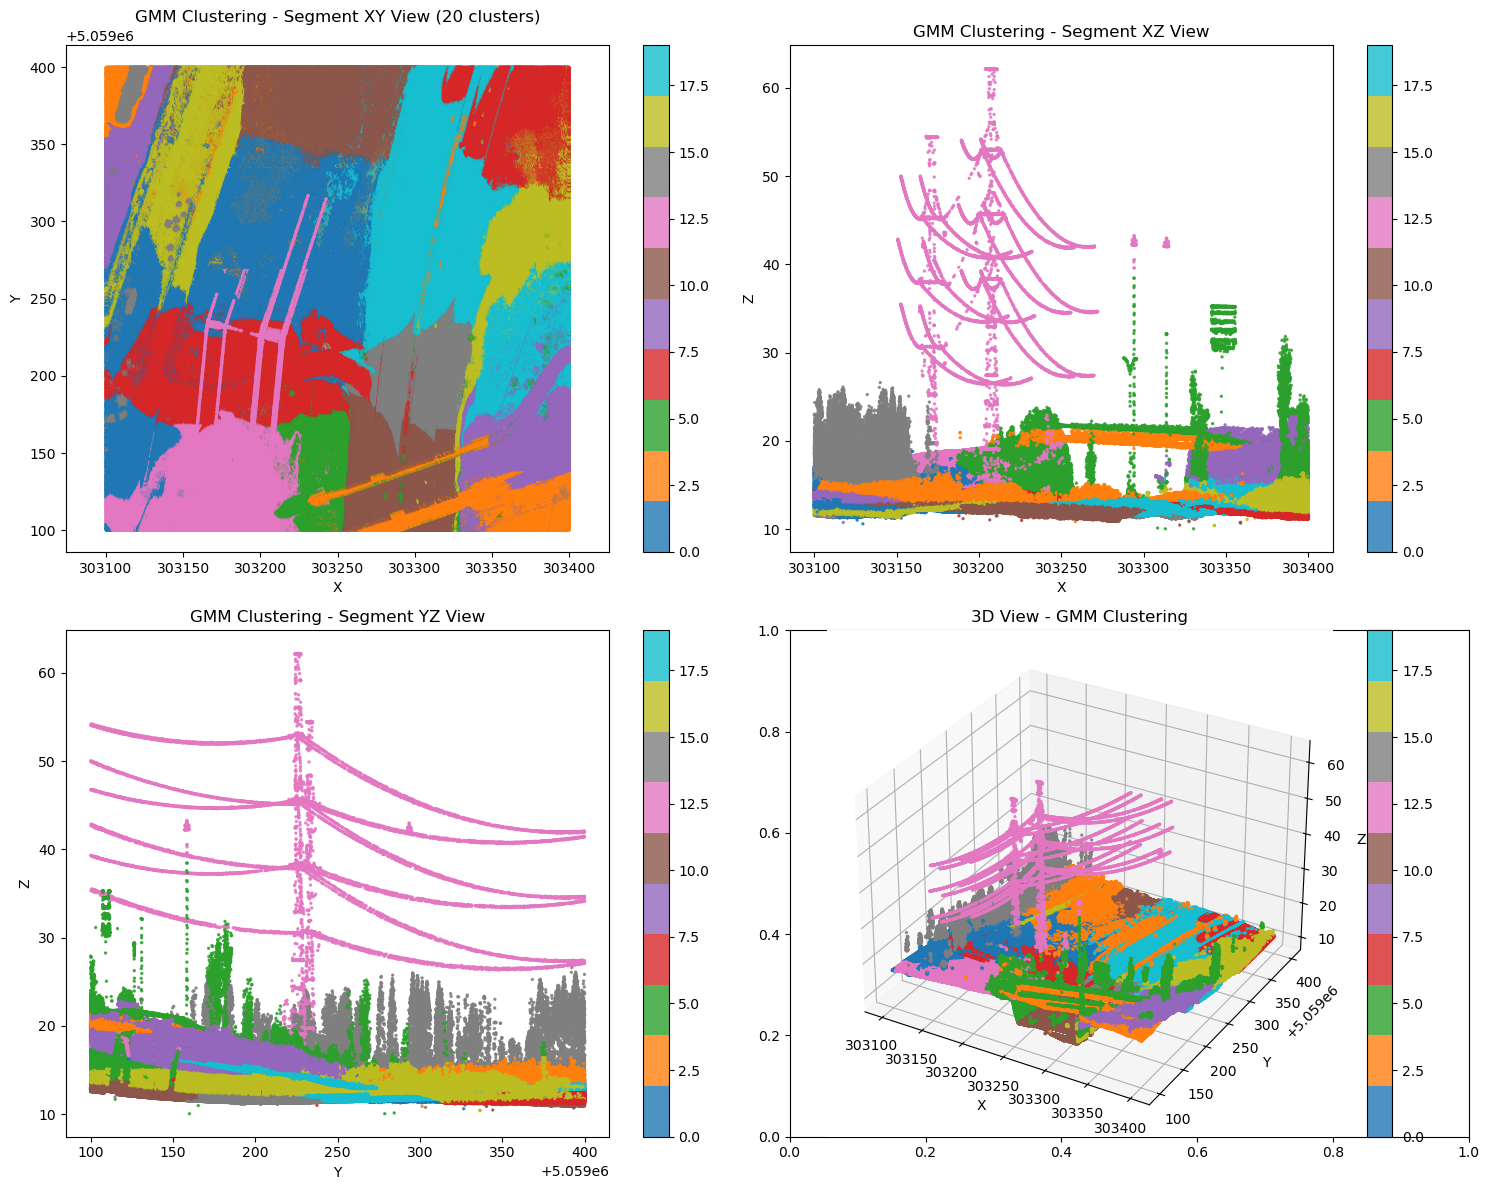

In [24]:
# Visualize clustering results on segment
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# XY view
scatter1 = axes[0,0].scatter(segment_points['x'], segment_points['y'], 
                            c=segment_points['gmm_cluster'], cmap='tab10', s=2, alpha=0.8)
axes[0,0].set_xlabel('X')
axes[0,0].set_ylabel('Y')
axes[0,0].set_title(f'GMM Clustering - Segment XY View ({n_components} clusters)')
plt.colorbar(scatter1, ax=axes[0,0])
axes[0,0].axis('equal')

# XZ view
scatter2 = axes[0,1].scatter(segment_points['x'], segment_points['z'], 
                            c=segment_points['gmm_cluster'], cmap='tab10', s=2, alpha=0.8)
axes[0,1].set_xlabel('X')
axes[0,1].set_ylabel('Z')
axes[0,1].set_title('GMM Clustering - Segment XZ View')
plt.colorbar(scatter2, ax=axes[0,1])

# YZ view
scatter3 = axes[1,0].scatter(segment_points['y'], segment_points['z'], 
                            c=segment_points['gmm_cluster'], cmap='tab10', s=2, alpha=0.8)
axes[1,0].set_xlabel('Y')
axes[1,0].set_ylabel('Z')
axes[1,0].set_title('GMM Clustering - Segment YZ View')
plt.colorbar(scatter3, ax=axes[1,0])

# 3D view
from mpl_toolkits.mplot3d import Axes3D
ax3d = fig.add_subplot(2, 2, 4, projection='3d')
scatter4 = ax3d.scatter(segment_points['x'], segment_points['y'], segment_points['z'], 
                       c=segment_points['gmm_cluster'], cmap='tab10', s=2, alpha=0.8)
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')
ax3d.set_zlabel('Z')
ax3d.set_title('3D View - GMM Clustering')
plt.colorbar(scatter4, ax=ax3d)

plt.tight_layout()
plt.show()